# Tarea 6. Optmización, Gradiente Conjugado

## Oscar Esaú Peralta Rosales
### Maestria en Ciencias de la Computación

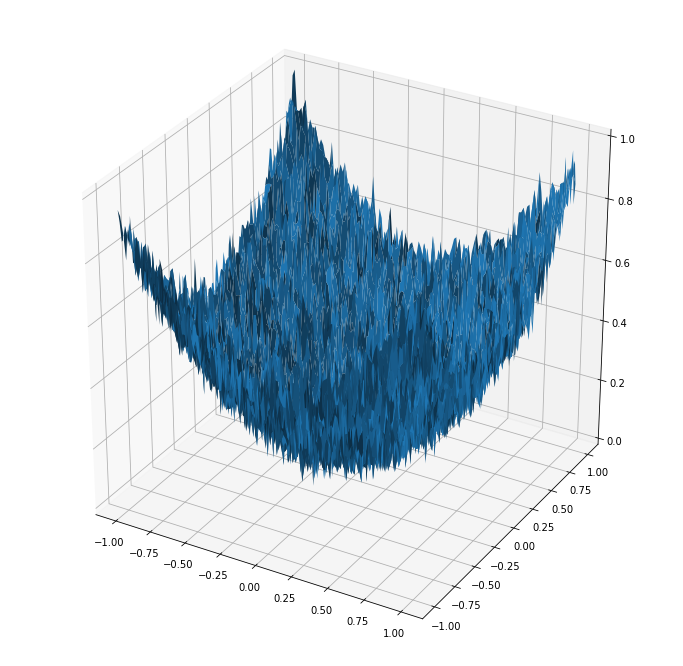

In [35]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
n = 128
x = y = np.linspace(-1, 1, n)
x , y = np.meshgrid (x, y)
g = x**2 + y**2 + 0.1 * np.random.randn(*x.shape)
g = (g - g.min()) / (g.max() - g.min())
ax.plot_surface(x, y, g)

In [36]:
g.shape

(128, 128)

## Gradiente Conjugado

In [0]:
def gc(X: np.array,
       f: Callable[[np.array], np.array],
       g: Callable[[np.array], np.array],
       tol_g: float=1e-12,
       mxitr: int=1000,
       **kwargs):
    Result = namedtuple('Result', 'x_log f_log g_norm_log')

    # Logs 
    x_log = []
    f_log = []
    g_norm_log = []

    # x_k
    x_k = X
    x_k_next = None
    x_log.append(x_k)

    # f_k
    f_k = f(x_k, **kwargs.get('f_kwargs', {}))
    f_log.append(f_k)

    # g_k
    g_k = g(x_k, **kwargs.get('g_kwargs', {}))
    g_k_next = None
    g_norm_log.append(np.linalg.norm(g_k))

    #
    get_q_k = kwargs.get('Q')
    d_k = -g_k
    gg_k = g_k.dot(g_k)
    
    # H = kwargs['H']

    k = 0
    while g_norm_log[-1] > tol_g and k < mxitr:
        q_k = get_q_k(d_k, **kwargs['Q_kwargs'])
        
        alpha_k = - (g_k.dot(d_k)) / (d_k.dot(q_k) )
        
        x_k = x_k + alpha_k * d_k
        x_log.append(x_k)
        
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        g_norm_log.append(np.linalg.norm(g_k))
        
        beta_k = (g_k.dot(q_k)) / (d_k.dot(q_k))
        
        d_k = -g_k + beta_k * d_k

        f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        if k%10 == 0:
            print(f_log[-1], g_norm_log[-1])
        k += 1


    return Result(x_log, f_log, g_norm_log)


## Función a optimizar 

In [0]:
def f(x, v, lmda=None, ncols=None):
    size = x.shape[0]

    in_range = lambda u: u >=0 and u < size
    same_row = lambda u, w: int(u/ncols) == int(w/ncols)

    pos1 = [-1, 1]
    pos2 = [ncols, -ncols]

    ans = 0
    for i in range(size):
        ans += (x[i] - v[i])**2

        ns = 0
        for p in pos1:
            k = i + p
            if not in_range(k) or not same_row(i, k):
                continue
            ns += (x[i] - x[k])**2
        
        for p in pos2:
            k = i + p
            if not in_range(k):
                continue
            ns += (x[i] - x[k])**2
        
        ans += lmda * ns

    return ans


def f_grad(x, v, lmda=None, ncols=None):
    size = x.shape[0]

    in_range = lambda u: u >=0 and u < size
    same_row = lambda u, w: int(u/ncols) == int(w/ncols)

    pos1 = [-1, 1]
    pos2 = [ncols, -ncols]

    g = np.zeros(size)
    g = 2 * (x - v)

    for i in range(size):
        ns = 0
        for p in pos1:
            k = i + p
            if not in_range(k) or not same_row(i, k):
                continue
            ns += (x[i] - x[k])
        
        for p in pos2:
            k = i + p
            if not in_range(k):
                continue
            ns += (x[i] - x[k])
        
        g[i] += 4 * lmda * ns

    return g


# No se usa en el gradiente, solo para verificar los cálculos
def f_hess(lmda=None, ncols=None, nrows=None):
    """ Retorn el hessiano """
    size = ncols * nrows

    in_range = lambda u: u >=0 and u < size
    same_row = lambda u, w: int(u/ncols) == int(w/ncols)

    pos1 = [-1, 1]
    pos2 = [ncols, -ncols]

    h = np.zeros((size, size))

    def count_A(i):
        count = 0
        for p in pos1:
            k = i + p
            count += 1 if in_range(k) and same_row(i, k) else 0
        for p in pos2:
            k = i + p
            count += 1 if in_range(k) else 0
        return count

    for i in range(size):
        h[i][i] = 2 + 4 * lmda * count_A(i)
        for p in pos1 + pos2:
            k = i + p
            if not in_range(k):
                continue
            h[i][k] = -4 * lmda
    
    return h


# Sustituimos Q en el gradiente por esta función
def f_hess_d(d_k, lmda=None, ncols=None, nrows=None):
    """ Return the vector Qd_k """
    size = ncols * nrows

    y = np.zeros(size, dtype=float)

    in_range = lambda u: u >=0 and u < size
    same_row = lambda u, w: int(u/ncols) == int(w/ncols)

    pos1 = [-1, 1]
    pos2 = [ncols, -ncols]

    def count_A(i):
        count = 0
        for p in pos1:
            k = i + p
            count += 1 if in_range(k) and same_row(i, k) else 0
        for p in pos2:
            k = i + p
            count += 1 if in_range(k) else 0
        return count

    for i in range(size):
        y[i] += (2 + 4 * lmda * count_A(i)) * d_k[i]
        for p in pos1 + pos2:
            k = i + p
            if not in_range(k):
                continue
            y[i] += (-4 * lmda) * d_k[k]
    
    return y

In [0]:
x_temp =np.array([1,2,3,4,5,6,7,8,9])
g_temp = np.zeros((9))

In [40]:
f(x_temp, g_temp, lmda=1, ncols=3)

405.0

In [41]:
f_grad(x_temp, g_temp, lmda=1, ncols=3)

array([-14.,  -8.,  -2.,   4.,  10.,  16.,  22.,  28.,  34.])

In [42]:
f_hess(lmda=1, ncols=3, nrows=3)

array([[10., -4.,  0., -4.,  0.,  0.,  0.,  0.,  0.],
       [-4., 14., -4.,  0., -4.,  0.,  0.,  0.,  0.],
       [ 0., -4., 10., -4.,  0., -4.,  0.,  0.,  0.],
       [-4.,  0., -4., 14., -4.,  0., -4.,  0.,  0.],
       [ 0., -4.,  0., -4., 18., -4.,  0., -4.,  0.],
       [ 0.,  0., -4.,  0., -4., 14., -4.,  0., -4.],
       [ 0.,  0.,  0., -4.,  0., -4., 10., -4.,  0.],
       [ 0.,  0.,  0.,  0., -4.,  0., -4., 14., -4.],
       [ 0.,  0.,  0.,  0.,  0., -4.,  0., -4., 10.]])

## Optimización

In [43]:
nrows, ncols = g.shape
lmda = 100

gp = g.reshape((nrows*ncols))
x0 = np.random.rand(nrows*ncols)

params = {
    'X': x0,
    'f': f,
    'f_kwargs': {
        'v': gp,
        'lmda': lmda,
        'ncols': ncols,
    },
    'g': f_grad,
    'g_kwargs': {
        'v': gp,
        'lmda': lmda,
        'ncols': ncols,
    },
    'tol_g': 1e-8,
    'mxitr': 100,
    'Q': f_hess_d, # Usamos la función que obtiene el vector resultante de Qd
    'Q_kwargs': {
        'lmda': lmda,
        'ncols': ncols,
        'nrows': nrows
    }
}

ans = gc(**params)

115085.26753182412 18127.961982872414
839.2301977084325 286.77474404614827
606.6330682914144 196.5015044353936
346.05359524048555 201.2965616430026
240.91283917856188 75.28070985593276
222.3069437111104 44.843608894442376
217.83221453306356 41.64572249922949
212.53320398521097 32.43994385708262
209.1398543920637 17.300778774806343
207.92898568960734 11.575641724908044


iters: 101
g norm 6.7917239578567
f 207.50007630670373


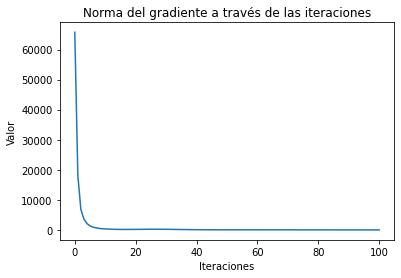

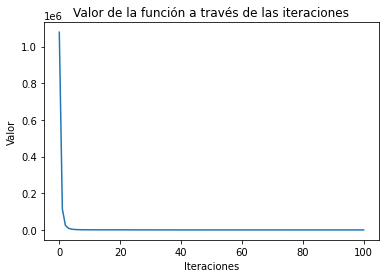

array([0.64365211, 0.64297148, 0.64163189, ..., 0.64628845, 0.64723578,
       0.64794715])

In [44]:
print("iters: %d" % len(ans.x_log))
print("g norm", ans.g_norm_log[-1])
print("f", ans.f_log[-1])

plt.plot(ans.g_norm_log)
plt.title('Norma del gradiente a través de las iteraciones')
plt.xlabel('Iteraciones')
plt.ylabel('Valor')
plt.show()

plt.plot(ans.f_log)
plt.title('Valor de la función a través de las iteraciones')
plt.xlabel('Iteraciones')
plt.ylabel('Valor')
plt.show()

ans.x_log[-1]

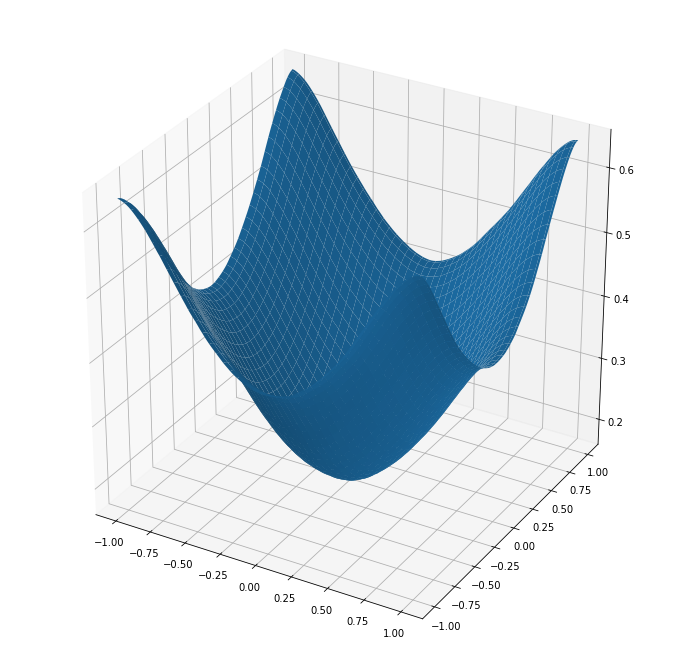

In [45]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, ans.x_log[-1].reshape((nrows, ncols)))